<a href="https://colab.research.google.com/github/poronita/Gesture-Recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import numpy as np

# Specify the paths to the training and validation data
base_path = '/content/drive/MyDrive/Upgrade Assignment /Project_data/Project_data'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

# Function to load data lists from CSV files
def load_data_list(data_path):
    with open(data_path, 'r') as f:
        data_list = f.readlines()
    return np.random.permutation(data_list)

# Load training and validation data lists
train_doc = load_data_list(os.path.join(base_path, 'train.csv'))
val_doc = load_data_list(os.path.join(base_path, 'val.csv'))

## Model Training Trial 01

In [20]:
from keras.preprocessing import image

def generator(source_path, folder_list, batch_size=16, img_size=(120, 120), frames_to_use=15):
    img_idx = np.round(np.linspace(0, 29, frames_to_use)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, frames_to_use, *img_size, 3))
            batch_labels = np.zeros((batch_size, 5))  # Assuming 5 classes for gestures
            for folder in range(batch_size):
                imgs = sorted(os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]))
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(source_path, t[folder + (batch*batch_size)].strip().split(';')[0], imgs[item])
                    img = image.load_img(img_path, target_size=img_size)
                    img = image.img_to_array(img) / 255.0
                    batch_data[folder, idx] = img
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [21]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, GRU, Dense, Dropout

def create_cnn_rnn_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(15, 120, 120, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [ ]:
model = create_cnn_rnn_model()
print(model.summary())

In [ ]:
# Training
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

history = model.fit_generator(generator(train_path, train_doc),
                              steps_per_epoch=len(train_doc)//16, epochs=10,
                              validation_data=generator(val_path, val_doc),
                              validation_steps=len(val_doc)//16,
                              callbacks=[checkpoint, reduce_lr], verbose=1)


In [ ]:
# Step 6: Plot Training and Validation Results
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def plot_training_history(history):
    # Extract accuracy and loss from the history object
    train_accuracy = history.history['categorical_accuracy']
    val_accuracy = history.history['val_categorical_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Determine the epoch with the best validation accuracy
    best_epoch = np.argmax(val_accuracy)
    best_val_accuracy = val_accuracy[best_epoch]

    # Print the summary
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")
    print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")


# Call the function to plot the training history and print the summary
plot_training_history(history)


## Model Training Trial 02

In [17]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import matplotlib.pyplot as plt

In [20]:
# Define paths for training and validation data
base_path = '/content/drive/MyDrive/Upgrade Assignment /Project_data/Project_data'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')

In [21]:
# Function to load CSV data into a shuffled array
def load_data_list(data_path):
    with open(data_path, 'r') as f:
        data_list = [line.strip() for line in f.readlines()]
    return np.random.permutation(data_list)

# Load training and validation data lists
train_doc = load_data_list(os.path.join(base_path, 'train.csv'))
val_doc = load_data_list(os.path.join(base_path, 'val.csv'))

In [22]:
# Generator function
def generator(source_path, folder_list, batch_size=16, img_size=(128, 128), frames_to_use=15):
    img_idx = np.round(np.linspace(0, 29, frames_to_use)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, frames_to_use, *img_size, 3))
            batch_labels = np.zeros((batch_size, 5))  # Assuming 5 gesture classes
            for folder in range(batch_size):
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])))
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(source_path, t[folder + (batch*batch_size)].split(';')[0], imgs[item])
                    img = image.load_img(img_path, target_size=img_size)
                    img = image.img_to_array(img) / 255.0
                    batch_data[folder, idx, :, :, :] = img
                batch_labels[folder, int(t[folder + (batch*batch_size)].split(';')[2])] = 1
            yield batch_data, batch_labels

In [23]:
# Model creation function
def create_cnn_rnn_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        TimeDistributed(base_model, input_shape=(15, 128, 128, 3)),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(5, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [24]:
# Initialize the model
model = create_cnn_rnn_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 15, 4, 4, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 15, 4, 4, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 15, 2, 2, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 15, 4096)          0         
 istributed)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [25]:
# Setup model training
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


In [26]:
# Train the model
history = model.fit(
    generator(train_path, train_doc, batch_size=16),
    steps_per_epoch=len(train_doc) // 16,
    epochs=20,
    validation_data=generator(val_path, val_doc, batch_size=16),
    validation_steps=len(val_doc) // 16,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 1.5443 - categorical_accuracy: 0.3308  
Epoch 1: val_loss improved from inf to 1.37424, saving model to model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2884s 72s/step - loss: 1.5443 - categorical_accuracy: 0.3308 - val_loss: 1.3742 - val_categorical_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 1.0007 - categorical_accuracy: 0.7652
Epoch 2: val_loss improved from 1.37424 to 0.99335, saving model to model_best.h5
41/41 [==============================] - 264s 6s/step - loss: 1.0007 - categorical_accuracy: 0.7652 - val_loss: 0.9933 - val_categorical_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 0.6089 - categorical_accuracy: 0.9009
Epoch 3: val_loss improved from 0.99335 to 0.83742, saving model to model_best.h5
41/41 [==============================] - 249s 6s/step - loss: 0.6089 - categorical_accuracy: 0.9009 - val_loss: 0.8374 - val_categorical_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 4/20
41/41 [==============================] - ETA: 0s - loss: 0.3612 - categorical_accuracy: 0.9604
Epo

In [27]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()


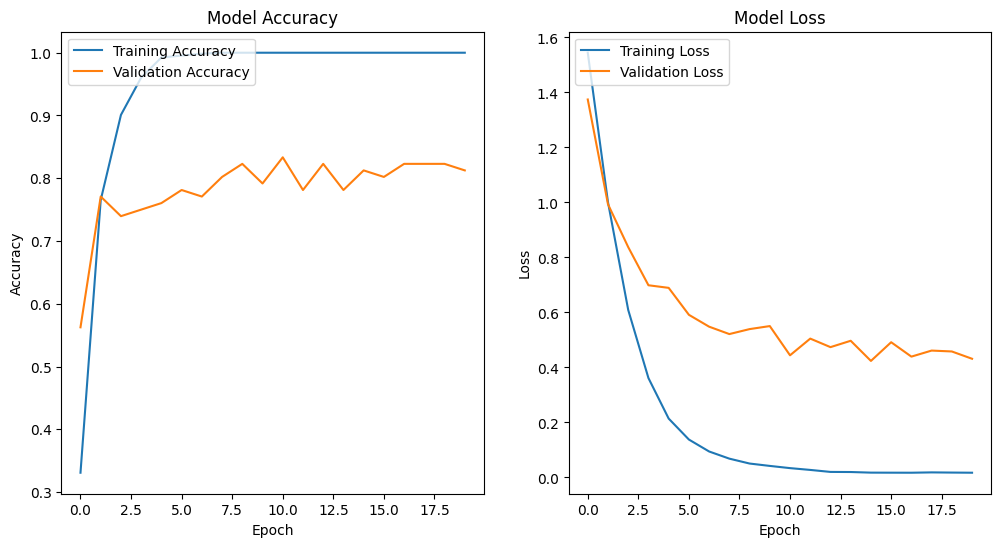

In [28]:
# Plot the training history
plot_training_history(history)

In [32]:
def plot_training_history(history):
    # Extract accuracy and loss from the history object
    train_accuracy = history.history['categorical_accuracy']
    val_accuracy = history.history['val_categorical_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Determine the epoch with the best validation accuracy
    best_epoch = np.argmax(val_accuracy)
    best_val_accuracy = val_accuracy[best_epoch]

    # Print the summary
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")
    print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")


# Call the function to plot the training history and print the summary
plot_training_history(history)

Best Validation Accuracy: 0.8333 at epoch 11
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8125
Final Training Loss: 0.0170
Final Validation Loss: 0.4314


## Model Training Trial 03

In [13]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import matplotlib.pyplot as plt

In [14]:
from keras.preprocessing import image

In [15]:
# Generator for 3D CNN
def generator_3d(source_path, folder_list, batch_size=16, frames_to_use=15, img_size=(128, 128)):
    img_idx = np.round(np.linspace(0, 29, frames_to_use)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, frames_to_use, *img_size, 3))
            batch_labels = np.zeros((batch_size, 5))  # Assuming 5 gesture classes
            for folder in range(batch_size):
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])))
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(source_path, t[folder + (batch*batch_size)].split(';')[0], imgs[item])
                    img = image.load_img(img_path, target_size=img_size)
                    img = image.img_to_array(img) / 255.0
                    batch_data[folder, idx, :, :, :] = img
                batch_labels[folder, int(t[folder + (batch*batch_size)].split(';')[2])] = 1
            yield batch_data, batch_labels

In [16]:
# 3D CNN Model Creation
def create_3d_cnn_model(frames_to_use=15, img_width=128, img_height=128):
    input_shape = (frames_to_use, img_width, img_height, 3)
    inputs = Input(input_shape)

    x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [17]:
model_3d = create_3d_cnn_model()
model_3d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 128, 128, 3   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 15, 128, 128, 32   2624      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 64, 64, 32)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 7, 64, 64, 32)     128       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 64, 64, 64)     55360 

In [18]:
# Setup training
checkpoint_3d = ModelCheckpoint('model_3d_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr_3d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# Train the 3D CNN model
history_3d = model_3d.fit(
    generator_3d(train_path, train_doc, batch_size=16),
    steps_per_epoch=len(train_doc) // 16,
    epochs=5,  # Adjust based on your needs
    validation_data=generator_3d(val_path, val_doc, batch_size=16),
    validation_steps=len(val_doc) // 16,
    callbacks=[checkpoint_3d, reduce_lr_3d],
    verbose=1
)

Epoch 1/5
41/41 [==============================] - ETA: 0s - loss: 0.8264 - categorical_accuracy: 0.7729 
Epoch 1: val_loss did not improve from 4.34404
41/41 [==============================] - 971s 23s/step - loss: 0.8264 - categorical_accuracy: 0.7729 - val_loss: 12.7978 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 2/5
41/41 [==============================] - ETA: 0s - loss: 0.9570 - categorical_accuracy: 0.8018 
Epoch 2: val_loss improved from 4.34404 to 2.95108, saving model to model_3d_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1008s 24s/step - loss: 0.9570 - categorical_accuracy: 0.8018 - val_loss: 2.9511 - val_categorical_accuracy: 0.5938 - lr: 0.0010
Epoch 3/5
41/41 [==============================] - ETA: 0s - loss: 0.8848 - categorical_accuracy: 0.8034 
Epoch 3: val_loss improved from 2.95108 to 1.35473, saving model to model_3d_best.h5
41/41 [==============================] - 1027s 25s/step - loss: 0.8848 - categorical_accuracy: 0.8034 - val_loss: 1.3547 - val_categorical_accuracy: 0.7396 - lr: 0.0010
Epoch 4/5
41/41 [==============================] - ETA: 0s - loss: 0.8495 - categorical_accuracy: 0.7927 
Epoch 4: val_loss did not improve from 1.35473
41/41 [==============================] - 948s 23s/step - loss: 0.8495 - categorical_accuracy: 0.7927 - val_loss: 3.4466 - val_categorical_accuracy: 0.5938 - lr: 0.0010
Epoch 5/5
41/41 [==============================] - ETA: 0s - loss: 1.0615 - categorical_accuracy: 0.7424 
Epoch 5: val_loss did not improve from 1.354

In [33]:
model_3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


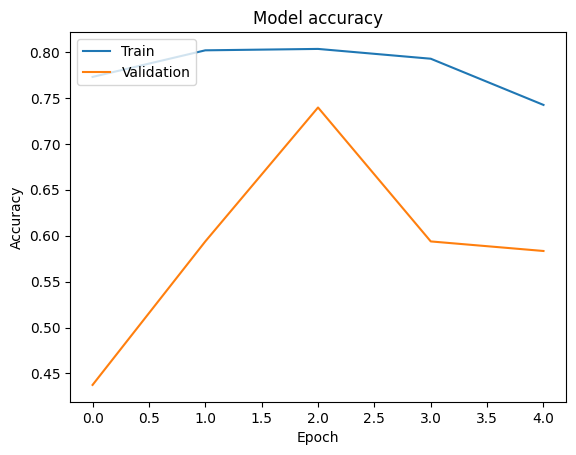

Final Training Accuracy: 0.7423780560493469
Final Validation Accuracy: 0.5833333134651184


In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_3d.history['categorical_accuracy'])
plt.plot(history_3d.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print final accuracy
print("Final Training Accuracy:", history_3d.history['categorical_accuracy'][-1])
print("Final Validation Accuracy:", history_3d.history['val_categorical_accuracy'][-1])


## Model Training Trial 04

In [ ]:
# Train the 3D CNN model
history_3d = model_3d.fit(
    generator_3d(train_path, train_doc, batch_size=16),
    steps_per_epoch=len(train_doc) // 16,
    epochs=20,
    validation_data=generator_3d(val_path, val_doc, batch_size=16),
    validation_steps=len(val_doc) // 16,
    callbacks=[checkpoint_3d, reduce_lr_3d],
    verbose=1
)

In [ ]:
model_3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_3d.history['categorical_accuracy'])
plt.plot(history_3d.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print final accuracy
print("Final Training Accuracy:", history_3d.history['categorical_accuracy'][-1])
print("Final Validation Accuracy:", history_3d.history['val_categorical_accuracy'][-1])